# part0: imports

In [254]:
import os, sys, pathlib
from pprint import pprint
import gc
import pickle
from importlib import reload
import logging, warnings
# logging.basicConfig(level=logging.ERROR)

import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
from matplotlib.collections import LineCollection
%matplotlib inline


import pyaldata as pyal

try:
    nbPath = pathlib.Path.cwd()
    RepoPath = nbPath.parent
    os.chdir(RepoPath)

    from tools import utilityTools as utility
    from tools import dataTools as dt
    import params
    reload(params)
    monkey_defs = params.monkey_defs
    mouse_defs = params.mouse_defs

    set_rc =  params.set_rc_params
    set_rc()
    root = params.root
    
    os.chdir(RepoPath / 'monkey')
    %run "_dataset-selection.ipynb"

finally:
    os.chdir(nbPath)

print('Done')

the variable `GoodDataList` contains the session names
Done


# Part 1

functions that plot each panel.

---

Raster panel

In [261]:
def prep_example_df():
    raster_example = ('Chewie_CO_FF_2016-10-13.p', 'Mihili_CO_VR_2014-03-03.p')
    raster_example_df = []
    for session in raster_example:
        path = root/session.split('_')[0]/session
        df = monkey_defs.prep_general(dt.load_pyal_data(path))
        df = pyal.restrict_to_interval(df, epoch_fun=monkey_defs.exec_epoch)
        raster_example_df.append(df)
    return raster_example_df


def plot_moneky_fr_raster(df,gs):
    trial=12
    axes = []
    data = []
    for tar in range(monkey_defs.n_targets):
        df_ = pyal.select_trials(df, df.target_id==tar)
        data.append(df_.M1_rates[trial])
    data = np.array(data)
    vmin = np.amin(data, axis= (0,1))
    vmax = np.amax(data, axis= (0,1))

    for j,tarData in enumerate(data):
        ax = fig.add_subplot(gs[j])
        axes.append(ax)
        tarData -= vmin
        tarData /= (vmax - vmin)
        ax.imshow(tarData.T, aspect='auto')
        ax.tick_params('both', bottom=False, left=False, labelbottom=False, labelleft=False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
    axes[0].set_ylabel(f'Units ($n={tarData.shape[1]}$)')
    return axes

def plot_moneky_vel_ex(df,gs):
    trial=12
    axes = []
    for tar in range(monkey_defs.n_targets):
        df_ = pyal.select_trials(df, df.target_id==tar)
        data = df_.vel[trial]
        ax = fig.add_subplot(gs[tar])
        axes.append(ax)
        ax.plot(data[:,0], label='$X$')
        ax.plot(data[:,1], label='$Y$')
        ax.tick_params('both', bottom=False, left=False, labelbottom=False, labelleft=False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
    
    return axes

/home/mostafa/Repositories/PyalData/pyaldata/firing_rates.py:88: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/mostafa/Repositories/PyalData/pyaldata/firing_rates.py:88: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/mostafa/Repositories/PyalData/pyaldata/firing_rates.py:88: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/mostafa/Repositories/PyalData/pyaldata/firing_rates.py:88: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


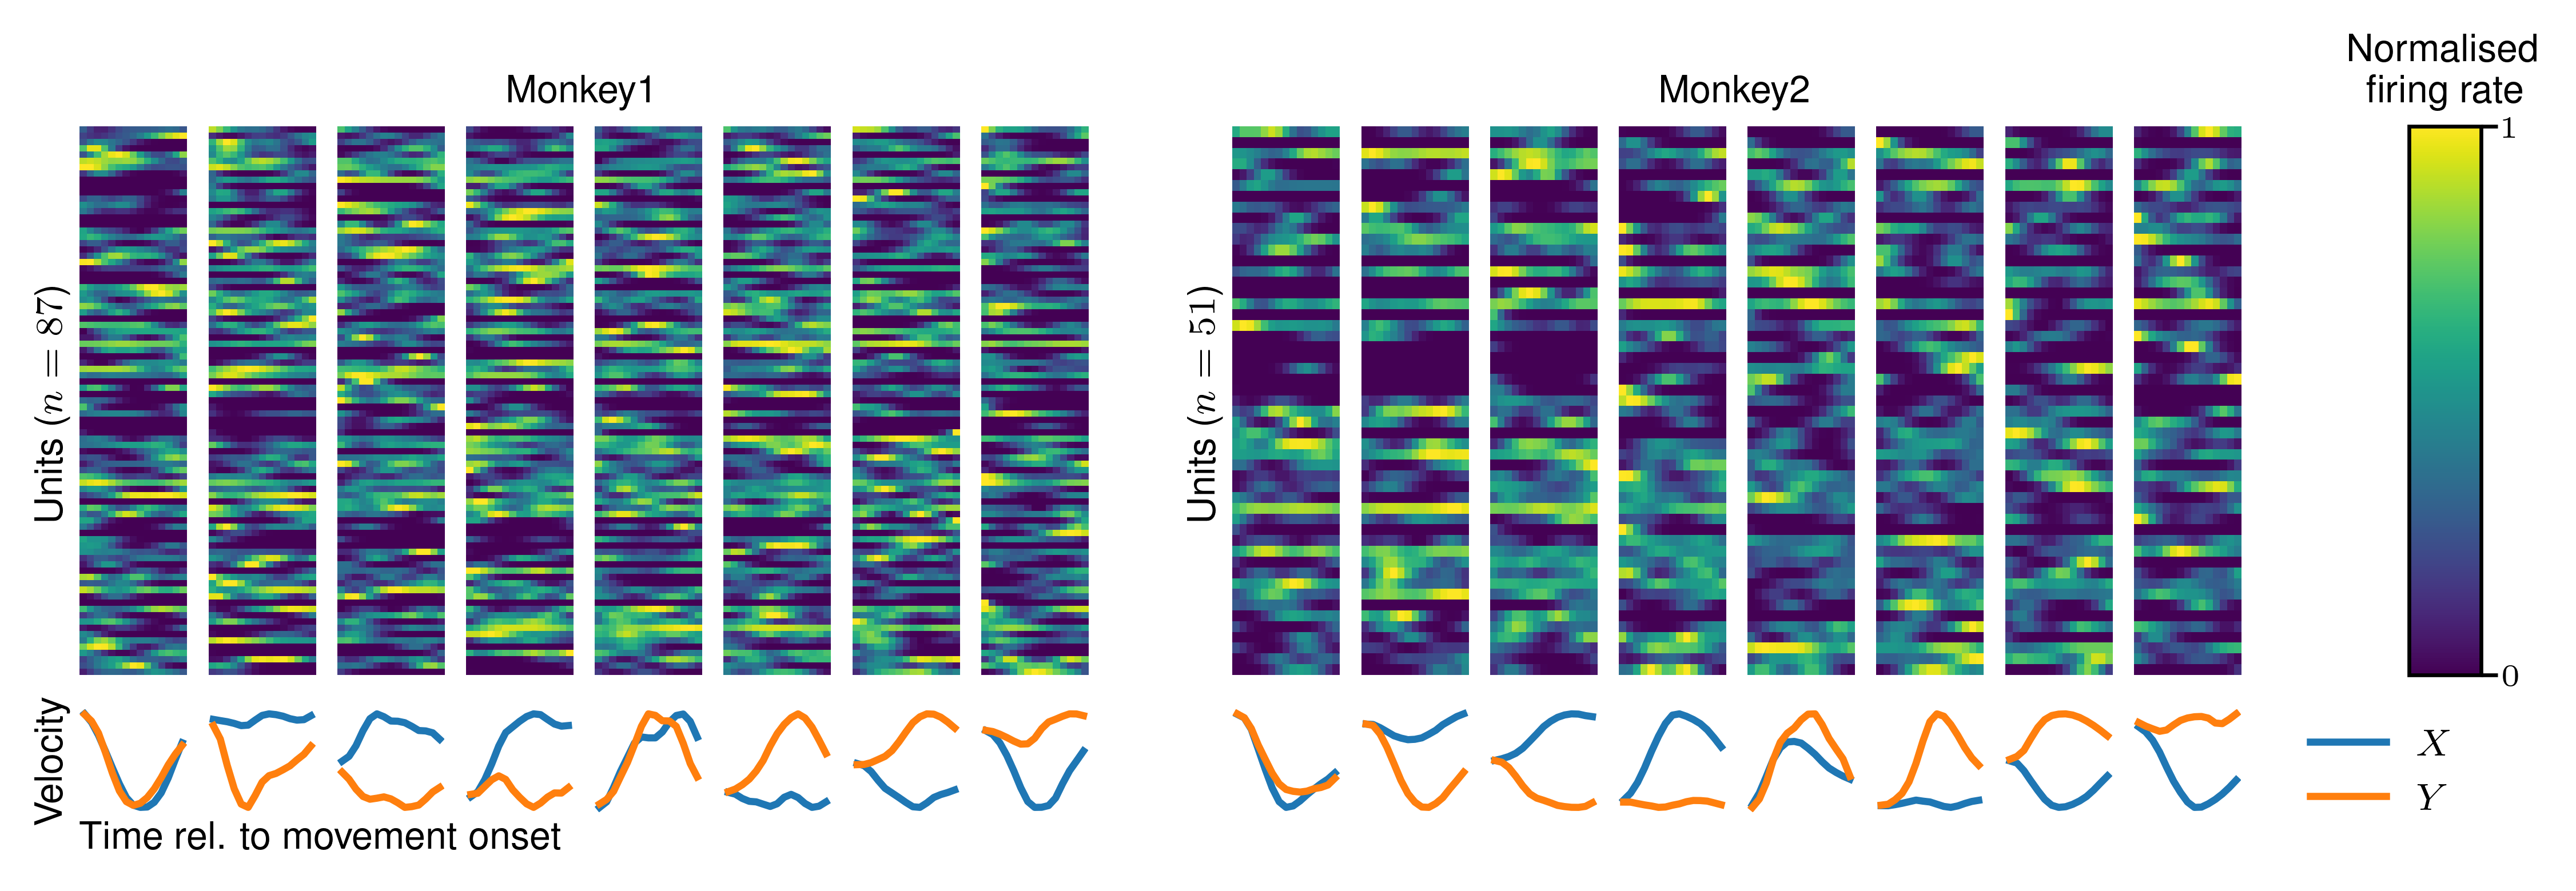

In [139]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()

    fig=plt.figure(figsize=(7,2))

    plot_moneky_fr_raster(ax)
    
    
    plt.show()

3D dynamics panel

In [78]:
def plot_monkey_pc_example(gs):   
    raster_example_df = prep_example_df()
    fig=gs.figure
    
    colors = utility.get_colors(8)
    dfs=[]
    axes=[]
    for i,df in enumerate(raster_example_df):
        rates = np.concatenate(df['M1_rates'].values, axis=0)
        rates -= np.mean(rates, axis=0)
        rates_model = PCA(n_components=10, svd_solver='full').fit(rates)
        df_ = pyal.apply_dim_reduce_model(df, rates_model, 'M1_rates', '_pca');
        dfs.append(df_)
        ax = fig.add_subplot(gs[i], projection='3d',fc='None')
        axes.append(ax)
        for tar in range(monkey_defs.n_targets):
            df__ = pyal.select_trials(df_, df_.target_id==tar)
            ex = pyal.get_sig_by_trial(df__,'_pca')
            ex = np.mean(ex, axis=2)[:,:3]
            ax.plot(ex[:,0],ex[:,1],ex[:,2],color=colors[tar],lw=1)
            ax.view_init(60,-47)

    AllData = dt.get_data_array(raster_example_df, area='M1', model=10)
    data1 = np.reshape(AllData[0,...], (-1,10))
    data2 = np.reshape(AllData[1,...], (-1,10))
    A,B,*_ = dt.canoncorr(data1,data2,fullReturn=True)
    coef_ = [A,B]
    for i,sessionData in enumerate(AllData):
        ax = fig.add_subplot(gs[i+3], projection='3d',fc='None')
        axes.append(ax)
        for tar in range(8):
            ex = np.mean(sessionData[tar,...], axis=0)
            ex = ex @ coef_[i]
            ax.plot(ex[:,0],ex[:,1],ex[:,2],color=colors[tar],lw=1)
            ax.view_init(60,-47)

    titles=[r'Monkey1 (\textit{unaligned})',r'Monkey2 (\textit{unaligned})',
            r'Monkey1 (\textit{aligned})',  r'Monkey2 (\textit{aligned})']
    labels = ['PC','PC','CC','CC']
    for i, ax in enumerate(axes):
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        ax.set_xlabel(f'{labels[i]}1', labelpad=-15)
        ax.set_ylabel(f'{labels[i]}2', labelpad=-15)
        ax.set_zlabel(f'{labels[i]}3', labelpad=-15)
        ax.set_title(titles[i], pad=0, loc='center')
    
    #======== add the arrow
    
    ax = fig.add_subplot(gs[2], fc='None')
    ax = utility.phantom_axes(ax)
    ax.arrow(0,0,1,0,length_includes_head=True, width=.005, head_width=.015,head_length=.1, ec='k', fc='k')
    ax.set_ylim([-.1,.1])
    ax.set_xlim([-.5,1.1])
    ax.text(0.5,0.01,'CCA', ha='center', va='bottom')
    ax.text(0.5,-0.02,'(alignment)', ha='center', va='top')

/home/mostafa/Repositories/PyalData/pyaldata/firing_rates.py:88: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/mostafa/Repositories/PyalData/pyaldata/firing_rates.py:88: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/mostafa/Repositories/PyalData/pyaldata/firing_rates.py:88: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/mostafa/Repositories/PyalData/pyaldata/firing_rates.py:88: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


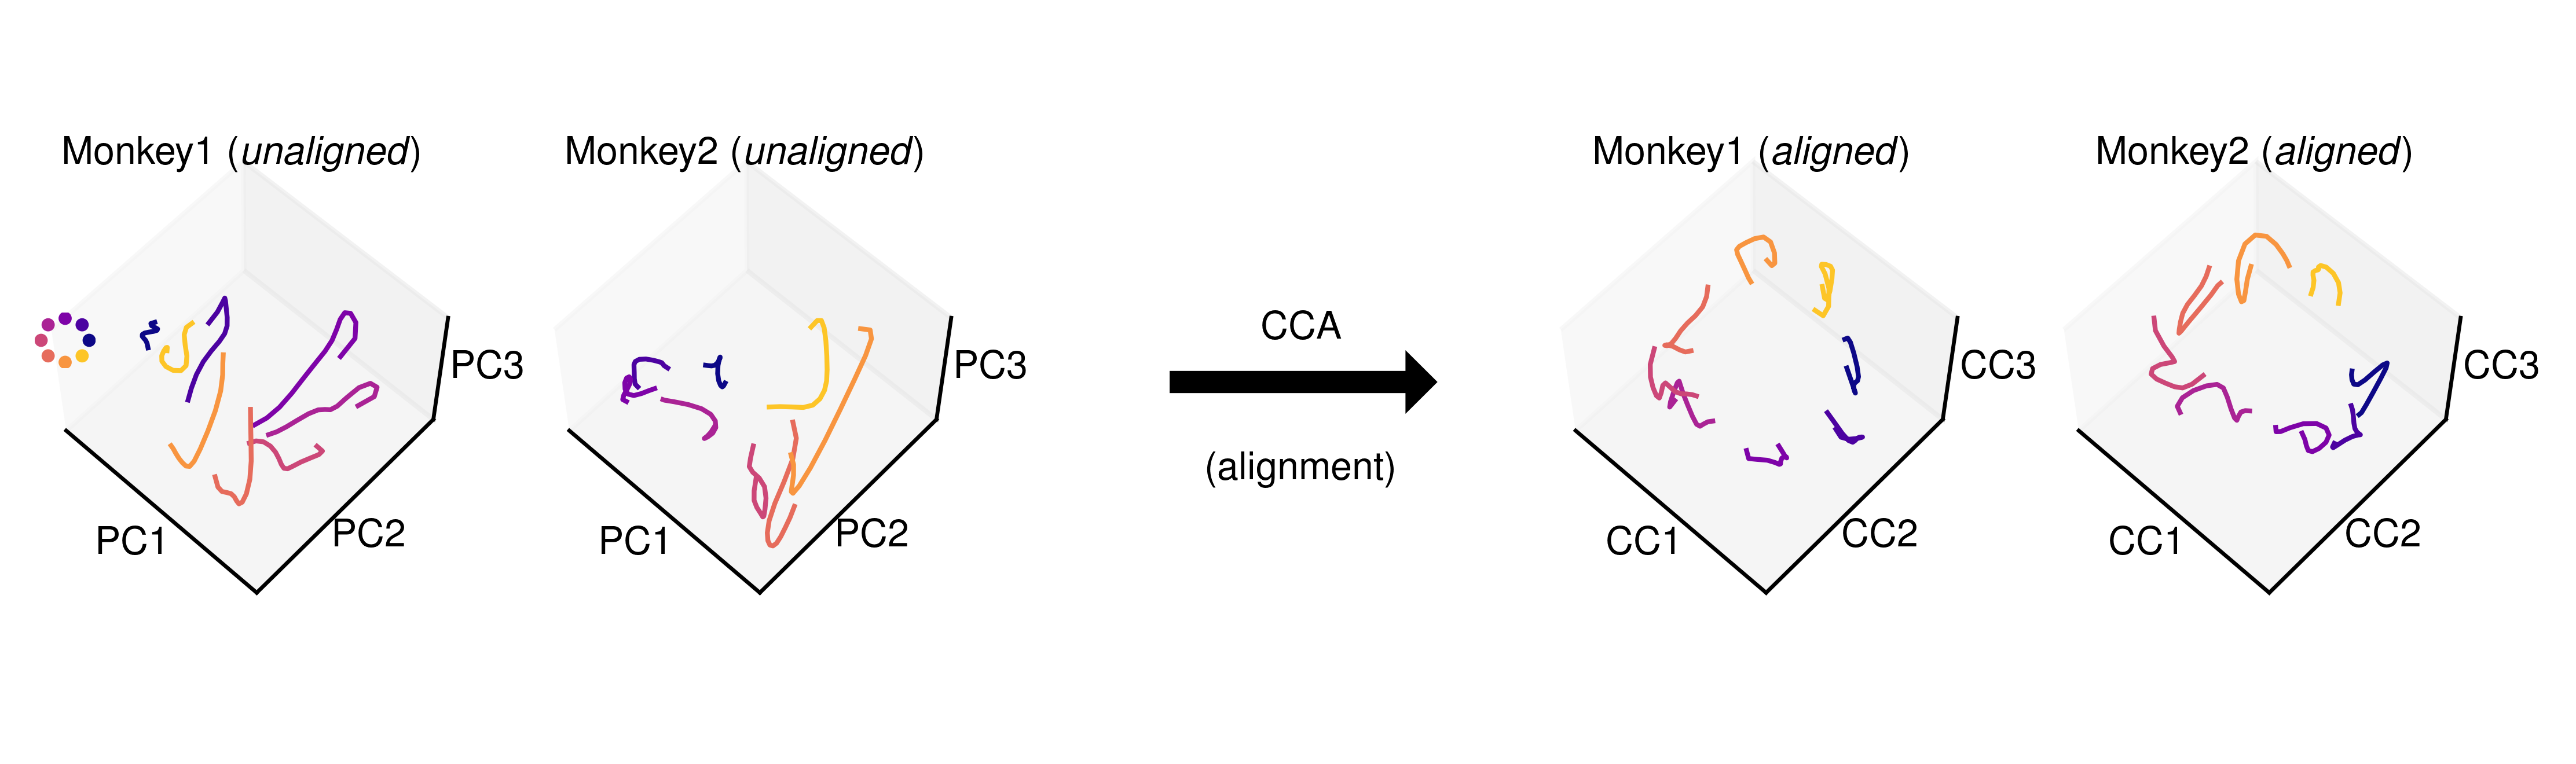

In [79]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    fig=plt.figure(figsize=(7,2))
    ax=fig.add_subplot(111)

    plot_monkey_pc_example(ax)
    
    
    plt.show()

# Part 2
Plot figure

/home/mostafa/Repositories/PyalData/pyaldata/firing_rates.py:88: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/mostafa/Repositories/PyalData/pyaldata/firing_rates.py:88: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/mostafa/Repositories/PyalData/pyaldata/firing_rates.py:88: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/mostafa/Repositories/PyalData/pyaldata/firing_rates.py:88: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


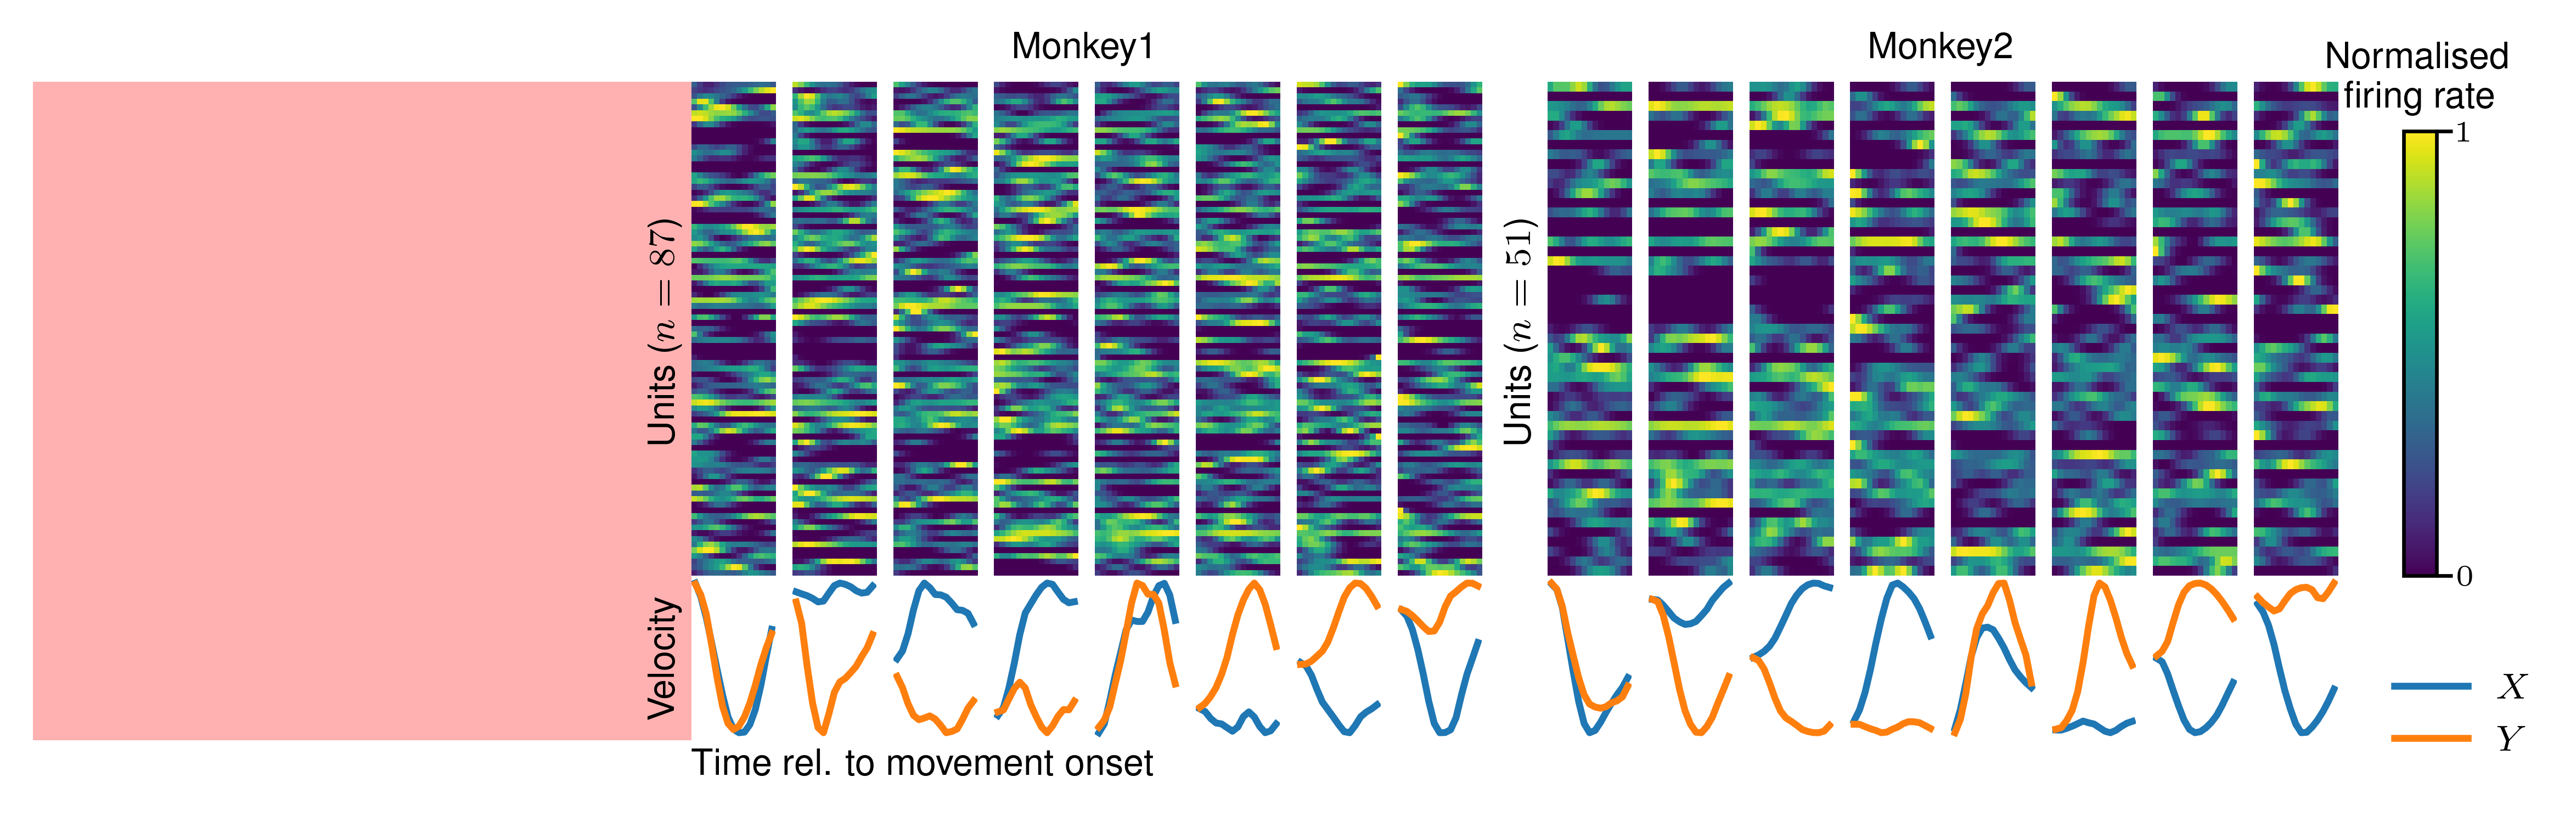

In [272]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    figsize=params.LargeFig
    fig=plt.figure(figsize=figsize,dpi=600)
    
   

    ##########################################
    # 1: schematics
    gs1   =utility.add_gridspec_abs(fig, nrows=1, ncols=1, left=0, 
                                    bottom=figsize[1]-params.panels.schmatic[1], 
                                    width=params.panels.schmatic[0], 
                                    height=params.panels.schmatic[1])
    ax1   =fig.add_subplot(gs1[0])
    ax1 = utility.phantom_axes(ax1)
    ax1.set_facecolor([1,0,0,.3])


    ##########################################
    # 2: Raster
    gs2_1 = utility.add_gridspec_abs(fig, nrows=1, ncols=monkey_defs.n_targets,
                                     left=params.panels.schmatic[0],
                                     bottom=figsize[1]-params.panels.schmatic[1]+params.panels.velocity[1],
                                     width=params.panels.raster[0], 
                                     height=params.panels.raster[1])
    gs2_2 = utility.add_gridspec_abs(fig, nrows=1, ncols=monkey_defs.n_targets,
                                     right=figsize[0],
                                     top=figsize[1],
                                     width=params.panels.raster[0], 
                                     height=params.panels.raster[1])

    
    raster_example_df = prep_example_df()
    
    axes2_1 = plot_moneky_fr_raster(raster_example_df[0], gs2_1)
    axes2_2 = plot_moneky_fr_raster(raster_example_df[1], gs2_2)
    utility.phantom_axes(fig.add_subplot(gs2_1[:])).set_title('Monkey1')
    utility.phantom_axes(fig.add_subplot(gs2_2[:])).set_title('Monkey2')
    
    axes2_3 = plot_moneky_vel_ex(raster_example_df[0], gs2_3)
    axes2_4 = plot_moneky_vel_ex(raster_example_df[1], gs2_4)

    axes2_3[0].set_ylabel('Velocity')
    axes2_3[0].set_xlabel('Time rel. to movement onset',loc='left')
    axes2_4[-1].legend(frameon=False, loc=(1.5,-0.2))
    
    gs2_c = utility.add_gridspec_abs(fig, nrows=1, ncols=1, 
                                     height=params.panels.raster[1]-.15, 
                                     width=.1, 
                                     left=figsize[0]+.2, 
                                     bottom=figsize[1]-params.panels.schmatic[1]+params.panels.velocity[1])
    cax2 = fig.add_subplot(gs2_c[:])
    fig.colorbar(cm.ScalarMappable(),cax=cax2, ticks=(0,1),drawedges=False)
    cax2.set_title('Normalised\nfiring rate')


    
    
    ##########################################
    # 3: 3D projections
    gs3   =utility.add_gridspec_abs(fig, nrows=1, ncols=1, left=0, 
                                    bottom=figsize[1]-params.panels.schmatic[1]-params.panels.proj_3d_align[1], 
                                    width=params.panels.proj_3d_align[0], 
                                    height=params.panels.proj_3d_align[1])

    gs   =fig.add_gridspec(nrows=1, ncols=5, left=0, bottom=0, right=1, top=1)
    gs_c = fig.add_gridspec(nrows=1, ncols=1, left=0, bottom=0.52, right=.025, top=0.6, wspace=0, hspace=0)
    # cax = fig.add_subplot(gs_c[0],zorder=10)

    
    
    # plot_monkey_pc_example(ax3)
    
    
    # utility.plot_targets(cax,3)
    # cax.set_xlim(np.array(cax.get_xlim())*1.15)
    # cax.set_ylim(np.array(cax.get_ylim())*1.15)
